# Comparison with MDAnalysis

`MDAnalysis` also contains a tool for calculating the mean-squared displacements. So why use `kinisi` over `MDAnalysis`?

Well, the approach taken by `kinisi`, which is outlined in the [methodology](./methodology.html), uses a high precision approach to estimate the diffusion coefficent and offers an accurate estimate of the variance in the mean-squared displacements and diffusion coefficient from a single simulation.

In this notebook, we will compare the results from `MDAnalysis` and `kinisi`. 
First we will import the `kinisi.analyze.DiffusionAnalyzer` and `MDAnalysis.analysis.msd` classes.

In [10]:
import warnings

warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)

import numpy as np

from kinisi.analyze import DiffusionAnalyzer
import MDAnalysis.analysis.msd as msd
from MDAnalysis.transformations.nojump import NoJump

Next, we are going to need to do a little 'magic' to get `MDAnalysis` to read an `extended xyz` file.
Luckly `ASE` can help us out.

In [11]:
from ase.io import read
from MDAnalysis import Universe

Since this trajectory has a triclinic cell; we need to extract the cell dimensions and pass them to `MDAnalysis`.

In [12]:
atoms = read('LiPS.exyz', format='extxyz', index=':')

cell_dimensions = []
for frame in atoms:
    lengths = frame.cell.lengths()
    angles = frame.cell.angles()
    cell = [*lengths, *angles]
    cell_dimensions.append(cell)

We now have the cell dimensions ($a, b, c, \alpha, \beta, \gamma$) in an array. We now need to create an `MDAnalysis` `universe` and apply these dimension to it.

In [13]:
u = Universe('LiPS.exyz', 'LiPS.exyz', format='XYZ', topology_format='XYZ', dt=20.0/1000)
for ts, dims in zip(u.trajectory, cell_dimensions):
    ts.dimensions = dims

Now we add an unwrapping transformation to the `universe`, create the `MSD` object, run the analysis, and extract the results as a timeseries.

In [14]:
u.trajectory.add_transformations(NoJump())
MSD = msd.EinsteinMSD(u, select='type LI', msd_type='xyz', fft=True, verbose=False)
MSD.run(verbose=False)
mda_MSD = MSD.results.timeseries

100%|██████████| 896/896 [00:00<00:00, 5934.63it/s]


With the result from `MDAnalysis` in one hand we can now do the same thing in `kinisi` with the other. We can also extract the series of $\Delta t$ from `kinisi`.

In [15]:
params = {'specie': 'LI',
          'time_step': 0.001,
          'step_skip': 20,
          'n_steps': 250,
          'sampling': 'multi-origin',
          'progress': False}

xyz = {'dimension': 'xyz', 'bootstrap': False,'progress': False}
kinisi_from_universe = DiffusionAnalyzer.from_universe(u, parser_params=params, uncertainty_params=xyz)
kinisi_MSD = kinisi_from_universe.msd
time = kinisi_from_universe.dt

Putting the two analyses' together, we can plot for comparison.

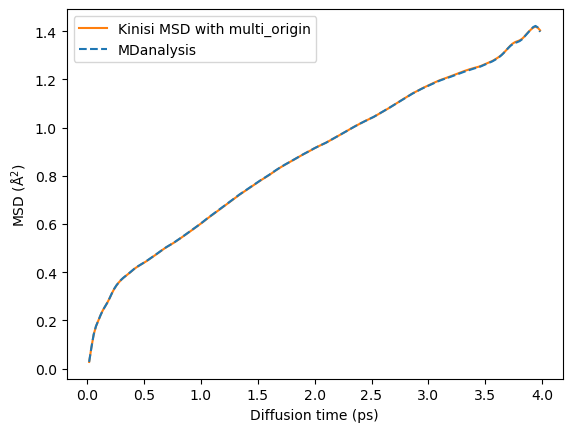

In [16]:
import matplotlib.pyplot as plt

plt.plot(time[:-1], kinisi_MSD[:-1], label='Kinisi MSD with multi_origin', c='#ff7f0e')
plt.plot(time[:-1], mda_MSD[1:], label='MDanalysis', ls='--')
plt.ylabel('MSD (Å$^2$)')
plt.xlabel('Diffusion time (ps)')
plt.legend()


plt.show()

The results overlap almost entirely.

We can now extract an accurate estimation of the variance in the observed MSD from `kinisi`. For clarity, we will use array indexing to remove every other data point.

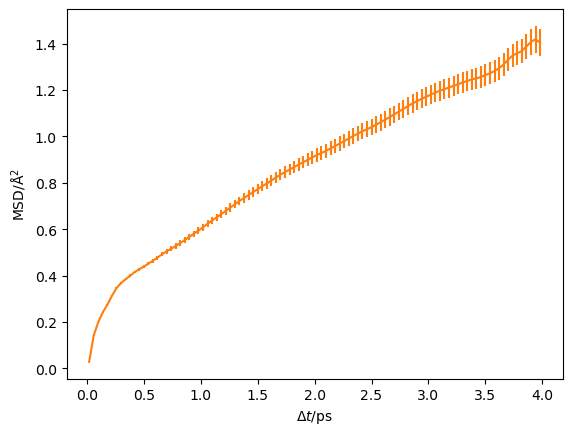

In [17]:
plt.errorbar(kinisi_from_universe.dt[::2],
             kinisi_from_universe.msd[::2],
             kinisi_from_universe.msd_std[::2],
             c='#ff7f0e')
plt.ylabel(r'MSD/Å$^2$')
plt.xlabel(r'$\Delta t$/ps')
plt.show()

We can also calculate estimated diffusion coefficient, and the associated uncertainty, with `kinisi`.

In [18]:
from uncertainties import ufloat

kinisi_from_universe.diffusion(kinisi_from_universe.ngp_max)
print('D from kinisi:', 
      ufloat(np.mean(kinisi_from_universe.D),
         np.std(kinisi_from_universe.D, ddof=1)))

Likelihood Sampling: 100%|██████████| 1500/1500 [00:01<00:00, 952.09it/s]

D from kinisi: (4.36+/-0.23)e-06
